# Module 3: Machine Learning

## Sprint 1: Basic Machine Learning

## House prices regression competition

## Background

---

Participating in Kaggle competitions is an efficient way to learn some aspects of Machine Learning. You can read solutions made public by the others, participate in the discussions to talk about solution ideas and test them by submitting them for evaluation.

The metric used for evaluation can vary from competition to competition, but the idea remains the same - build a model that is as accurate as possible on the testing set. In industry, there are other factors to consider when building machine learning models - inference time, solution complexity, maintainability and so on. However, even though you only learn a subset of the required skills while participating in Kaggle competitions, it is quite a fun way to learn by doing it, so let's participate in one of the tutorial competitions now!

## The competition

In the previous notebooks, we learned about some very important ML topics:

- Optimizing an objective
- Training, validation, testing sets
- Feature engineering
- Logistic regression model
- Linear regression model
- Random forest model
- Interpreting the model by looking at the important features

In this notebook we will practice all the above concepts by participating in another Kaggle competition:

- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

Read the overview and look at the evaluation section (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). The target to predict is a continuous variable and hence we will build regression models.

Give extra attention to the evaluation metric - the RMSE is computed between the logarithm of the predicted value and the logarithm of the observed sales price, not the raw prices.

Now look at the data section - inspect the columns that are available. Download the data and start with exploratory data analysis, similar to the one you used in the previous notebooks. Select some features, maybe do some feature engineering and build linear regression and random forest models using sklearn.

For help, you can look at some of the notebooks by other competitors. However, try to write code by yourself, as even though you will always be able to consult external resources while working as a professional, the main thing right now is to learn by first trying it yourself. These two notebooks could be useful:

- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python for exploratory data analysis
- https://www.kaggle.com/marcelopesse/house-prices-machine-learning-with-sklearn using random forests for regression

---

## Concepts to explore

- Linear regression https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- Random forest regressor https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- Root mean squared error https://en.wikipedia.org/wiki/Root-mean-square_deviation

## Requirements

- Train, validate (using a dedicated validation set) and submit a linear regression model
- Train, validate (using a dedicated validation set) and submit a random forest regressor model
- Achieve a score better than 0.14 on the public leaderboard

## Evaluation criteria

- Public leaderboard score
- How simple is the model
- Code quality

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats

In [24]:
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')

In [6]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
train.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,...,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,...,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,...,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,...,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,...,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,...,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.0

In [8]:
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
549,550,60,FV,75.0,9375,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,912,912,GasA,...,Y,SBrkr,912,1182,0,2094,0,0,2,1,4,1,Gd,8,Typ,1,Gd,BuiltIn,2003.0,Fin,2,615,TA,TA,Y,182,182,0,0,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal,263000
1358,1359,160,FV,NaN,2117,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,6,5,2000,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,216.0,Gd,TA,PConc,Gd,TA,No,GLQ,378,Unf,0,378,756,GasA,...,Y,SBrkr,769,804,0,1573,0,0,2,1,3,1,Gd,5,Typ,0,NaN,Detchd,2000.0,Unf,2,440,TA,TA,Y,0,32,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,177500
1155,1156,20,RL,90.0,10768,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Veenker,Norm,Norm,1Fam,1Story,5,8,1976,2004,Gable,CompShg,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Gd,ALQ,1157,Unf,0,280,1437,GasA,...,Y,SBrkr,1437,0,0,1437,1,0,2,0,3,1,Gd,6,Typ,1,Fa,Attchd,1976.0,RFn,2,528,TA,TA,Y,0,21,0,0,180,0,NaN,NaN,NaN,0,7,2007,WD,Normal,218000
52,53,90,RM,110.0,8472,Grvl,NaN,IR2,Bnk,AllPub,Corner,Mod,IDOTRR,RRNn,Norm,Duplex,1Story,5,5,1963,1963,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,TA,CBlock,Gd,TA,Gd,LwQ,104,GLQ,712,0,816,GasA,...,N,SBrkr,816,0,0,816,1,0,1,0,2,1,TA,5,Typ,0,NaN,CarPort,1963.0,Unf,2,516,TA,TA,Y,106,0,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,110000
303,304,20,RL,70.0,9800,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,7,1972,1972,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,TA,TA,No,ALQ,894,Unf,0,0,894,GasA,...,Y,SBrkr,894,0,0,894,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1975.0,Unf,2,552,TA,TA,Y,256,0,0,0,0,0,NaN,GdWo,NaN,0,7,2006,WD,Abnorml,149900


In [25]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [26]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
train.shape

(1460, 81)

In [13]:
test.shape

(1459, 80)

In [14]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5
GarageQual,81,5.5


In [32]:
train.PoolQC.value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [15]:
new_train = train.copy()

In [27]:
new_train['LotFrontage'].fillna(value=0, inplace = True)
new_train['GarageYrBlt'].fillna(value=0, inplace = True)
new_train['MasVnrArea'].fillna(value=0, inplace = True)
new_train['Electrical'].fillna(value='SBrkr', inplace = True)

In [28]:
new_train.fillna(value='None', inplace = True)

In [29]:
missing_values_new = missing_values_table(new_train)
missing_values_new.head(20)

Your selected dataframe has 81 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [38]:
new_train.Electrical.unique()


array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

In [23]:
missing_values = missing_values_table(test)
missing_values.head(20)

Your selected dataframe has 80 columns.
There are 33 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1456,99.8
MiscFeature,1408,96.5
Alley,1352,92.7
Fence,1169,80.1
FireplaceQu,730,50.0
LotFrontage,227,15.6
GarageCond,78,5.3
GarageYrBlt,78,5.3
GarageQual,78,5.3
GarageFinish,78,5.3


In [35]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [36]:
new_train.dtypes.value_counts()

object    46
int64     35
dtype: int64

In [30]:
new_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

MSZoning           5
LotFrontage      111
Street             2
Alley              3
LotShape           4
LandContour        4
Utilities          2
LotConfig          5
LandSlope          3
Neighborhood      25
Condition1         9
Condition2         8
BldgType           5
HouseStyle         8
RoofStyle          6
RoofMatl           8
Exterior1st       15
Exterior2nd       16
MasVnrType         4
MasVnrArea       328
ExterQual          4
ExterCond          5
Foundation         6
BsmtQual           5
BsmtCond           5
BsmtExposure       5
BsmtFinType1       7
BsmtFinType2       7
Heating            6
HeatingQC          5
CentralAir         2
Electrical         5
KitchenQual        4
Functional         7
FireplaceQu        6
GarageType         7
GarageYrBlt       98
GarageFinish       4
GarageQual         6
GarageCond         6
PavedDrive         3
PoolQC             4
Fence              5
MiscFeature        5
SaleType           9
SaleCondition      6
dtype: int64

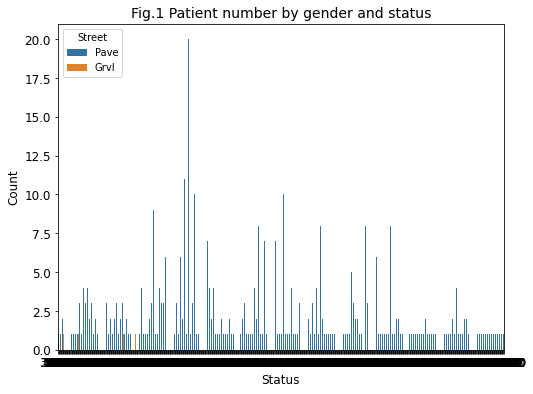

In [41]:
plt.figure(figsize=(8, 6))
sns.countplot(x = 'SalePrice', data=new_train, hue='Street')
plt.title('Fig.1 Patient number by gender and status', fontsize=14)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Text(0.5, 0, 'Province')

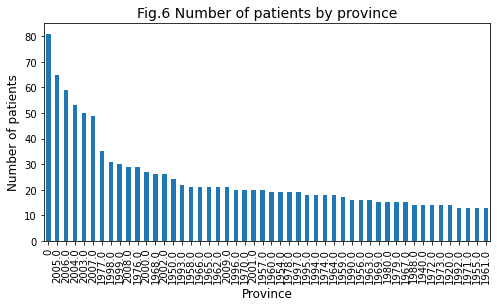

In [46]:
new_train.GarageYrBlt.value_counts().nlargest(50).plot(kind='bar', figsize=(8,4))
plt.title('Fig.6 Number of patients by province', fontsize=14)
plt.ylabel('Number of patients', fontsize=12)
plt.xlabel('Province', fontsize=12)